In [1]:
# -*- coding: utf-8 -*-
import os, math, random, re, cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import shapely.wkt
from osgeo import gdal, ogr, osr
from shapely.geometry import Polygon, MultiPolygon, LineString, MultiLineString, Point, MultiPoint, LinearRing
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
def plot_image(image, cmap=plt.cm.gray, title=None):
    fig = plt.figure()
    plt.imshow(image, cmap=cmap)
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.show()

/Users/mac/.pyenv/versions/anaconda2-4.4.0/lib/python2.7/site-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (138086400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


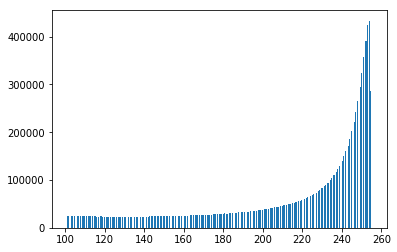

In [3]:
mask = plt.imread("predict.tif")
tmp = mask.flatten()[mask.flatten()>100]
n, bins, patches = plt.hist(tmp, 256)

In [4]:
# threshold, mask = cv2.threshold(mask, 240, 256, cv2.THRESH_OTSU)
threshold, mask = cv2.threshold(mask, 130, 256, cv2.THRESH_BINARY)
kernel = np.ones((2, 2), np.uint8)
opend = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=5)
close = cv2.morphologyEx(opend, cv2.MORPH_CLOSE, kernel, iterations=5)

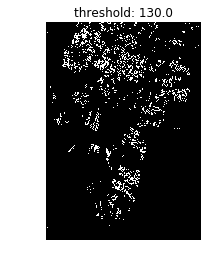

In [5]:
plot_image(close, title="threshold: {}".format(threshold))

In [6]:
_, contours, _ = cv2.findContours(close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
approx_contours = [cv2.approxPolyDP(cnt, 3, True) for cnt in contours]

In [7]:
len(approx_contours)

5766

In [8]:
polygons = []
linestrings = []
points = []
linerings = []
for cnt in approx_contours:
    assert cnt.shape[1] == 1
    if cnt.shape[0] > 2:
        poly = Polygon(shell=cnt[:, 0, :])
        if poly.is_valid:
            polygons.append(poly)
        else:
            point_list = list(poly.exterior.coords)
            for i in range(len(point_list)-1):
                if i == len(point_list)-1:
                    ls = LineString((point_list[i], point_list[0]))
                else:
                    ls = LineString((point_list[i], point_list[i+1]))
                if ls.is_valid:
                    linestrings.append(ls)
                else:
                    print cnt[:, 0, :]
#     elif cnt.shape[0] > 1:
#         line = LineString(coordinates=cnt[:, 0, :])
#         linestrings.append(line)
#     else:
#         point = Point(cnt.reshape(2,))
#         points.append(point)
multi_polygon = MultiPolygon(polygons)
multi_linestring = MultiLineString(linestrings)
multi_point = MultiPoint(points)

geometry_collection = multi_polygon.union(multi_linestring).union(multi_point)

geometry_collection_wkt = shapely.wkt.dumps(geometry_collection)

multi_polygon_wkt = shapely.wkt.dumps(multi_polygon)

# ogr_gc = ogr.CreateGeometryFromWkt(geometry_collection_wkt)

In [9]:
with open("multi_polygon_wkt.txt", "a+") as f:
    f.write(multi_polygon_wkt)

In [10]:
len(polygons)

5673